<a href="https://colab.research.google.com/github/k4west/huggingface/blob/main/Bacon_study_chap7_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/07_question-answering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

# 🤗로 시작하는 AI 스터디 Week 11

* 학습범위: 트랜스포머를 활용한 자연어 처리 **Chapter 7 [질문 답변]**
* 발표자: 김은교
* 발표자료와 실습자료를 이 문서로 통합

## 개요


### **_이 노트북은 pytorch 1.12.1과 haystack 1.7.0을 사용하는 버전입니다._**

In [ ]:
!pip install -qq farm-haystack[colab]==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.5/641.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.4/237.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (s

In [ ]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7.2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 615, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 615 (delta 23), reused 5 (delta 3), pack-reused 569
Receiving objects: 100% (615/615), 60.21 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (311/311), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.14.5
Using haystack v1.7.0


In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
# haystack의 로깅을 끕니다.
# haystack은 다양한 검색엔진을 구축할 수 있는 end-to-end 프레임워크이다.
# 참고링크 https://m.blog.naver.com/ys10mjh/222303707112

import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 질문 답변

QA의 종류
- 추출적 QA: 문서에 있는 텍스트 일부를 질문의 답으로 추출
  - 오늘날 QA 시스템의 시초가 되는 두 단계 과정
  - 관련된 문서 추려내기 / 문서에서 원하는 답을 추출하기
- 커뮤니티 QA: 포럼의 사용자가 생성한 질문 답변 쌍을 수집
  - 의미 유사도 검색을 통해 새 질문에 가장 잘 맞는 답을 찾는다
- 롱-폼 QA: 개방형 질문에 한 문단 길이의 복잡한 답을 생성

- 테이블 데이터에도 QA수행 가능 -> 트랜스포머 모델 TAPAS
  - 최종 답을 생성하기 위해 집계과정을 거침

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

구글 검색 쿼리와 해당 답변의 스크린 샷

## 리뷰 기반 QA 시스템 구축하기
트랜스포머를 사용하여 QA 시스템을 만들어 보자!

### 7.1.1 데이터셋

사용할 데이터 셋: SubjQA
- 여섯 분야의 제품과 서비스에서 10,000여개의 영어 리뷰로 구성되어 있다.

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

**[제품에 관한 질문과 해당 리뷰 -> 밑줄 부분이 답]**
- 질문과 답이 주관적인 데이터셋

주관적인 질문은 사실 여부가 명확한 질문의 답을 찾는 과정보다 어려움

원인 (위의 리뷰를 기준으로)
- 나쁜 품질에 대한 기준은 주관적인 것이며, 품질이란 기준조차도 사람에 따라 정의가 다르다
- 쿼리의 중요 부분이 리뷰에 전혀 나타나지 않고 있다
  - 키워드 검색이나 입력 질문을 재구성하는 간단한 방식으로는 답을 구할 수 없다



In [ ]:
from datasets import get_dataset_config_names

#4장에서 사용했던 동일한 함수를 사용하여 어떤 서브셋을 사용할 수 있는지 확인
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

**전자제품용 QA 시스템 구축**

전자제품 (electronics) 서브셋을 다운로드 하기 위해 매개변수로 "electronics" 전달

In [ ]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

SubjQA는 각 질문의 답을 중첩된 딕셔너리로 저장한다

In [ ]:
#answers 열에 있는 행 하나 확인해보기

print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [ ]:
"""
데이터 셋 탐색을 수월하게 하기 위해
flatten()으로 중첩된 열을 펼치고 pandas DataFrame으로 변환
"""

import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


SubjQA 데이터셋의 많은 열 중에 이 장에서 QA 시스템을 구축할 때 중심이 되는 열들

|열 이름 | 설명 |
|---|---|
|title | 각 제품에 연관된 ASIN(Amazon Standard Identification Number)|
|question | 질문 |
|answers.text | 사람이 레이블링한 리뷰 텍스트 일부 |
|answers.answers_start | 답이 시작하는 문자 인덱스 |
|context | 고객 리뷰 |

위 열에 초점을 두고 훈련 샘플을 몇 개 살펴보기

In [ ]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


위 샘플에서 발견할 수 있는 특징
1. 질문이 문법적으로 바르지 않다
2. 빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담겼다
3. 시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트를 추출할 수 있다.

In [ ]:
# 리뷰에서 답변에 해당하는 텍스트를 추출해보기

start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])

sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

훈련 세트에 대략 어떤 종류의 질문이 있는지 알아보기 위해 몇 개의 흔한 단어로 시작하는 질문의 개수를 카운트해보기
- 흔한 단어: What, How, Is, Does, Do, Was, Where, Why

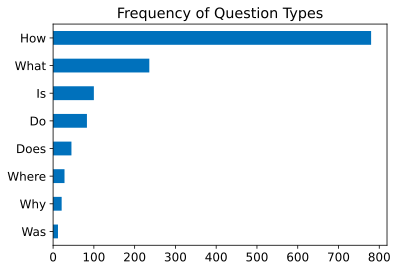

In [ ]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

"How", "What", "Is"가 제일 많은 것으로 나타남
- 각 단어로 시작하는 질문을 3개씩 랜덤으로 뽑아보기

In [ ]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### **참고)** 스탠포드 질문 답변 데이터셋 SQuAD (Stanford Qeustion Answering Dataset)

SubjQA의 형식인 (질문, 리뷰, [답변])은 추출적 QA 데이터셋에서 널리 사용되는데, 스탠퍼드 질문 답변 데이터셋 (SQuAD)에서 처음 사용된 방식이다.

- 컴퓨터가 텍스트 문단을 읽고 관련 질문에 답변이 가능한지 테스트할 때 많이 사용된다
- 원래 수백 개의 위키피디아 영어 문서에서 샘플링하고 크라우드 소싱을 통해 각 문단에서 일련의 질문과 답을 생성해 만들어졌다.
- 최초 버전에서는 각 질문의 답이 해당 구절 안에 반드시 존재했는데, 시퀀스 모델이 텍스트에서 정답을 추출하는 속도가 금세 사람을 앞지르기 시작함.

*초인적인 성능 != 진정한 독해 능력
- 답변 불가한 질문의 답은 보통 반의어 같은 텍스트에 있는 패턴을 통해 식별해내기 때문
- 해당 문제 해결 -> 구글이 자연질문 NQ 데이터셋을 릴리즈했다
  - 구글 검색 사용자에게서 수집한 사실 탐색 질문으로 구성된다
  - NQ에 있는 답변은 SQuAD에 있는 답변보다 훨씬 더 길고 더 어려운 벤치마크를 만든다고...



<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

### 7.1.2 텍스트에서 답 추출하기

QA 시스템에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 답변에 사용할 만한 부분을 식별해 낼 방법을 찾아야 한다.

이를 위해서 이해해야 하는 방법들
- 지도 학습 문제로 구성하기
- QA 직업을 위해 텍스트를 토큰화하고 인코딩하기
- 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

#### **범위 분류**

문제를 범위 분류 작업으로 구성하는 방법은 텍스트에서 답을 추출하는 가장 일반적인 방법

- 모델이 예측해야 하는 레이블: 답변 범위에 해당하는 시작 토큰 & 종료 토큰


<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

훈련 세트에는 비교적 적은 1,295개 샘플만 있으므로 SQuAD 같은 대규모 데이터셋에서 미세 튜닝한 언어 모델로 시작하는 것이 좋다
- 이런 모델을 대체로 독해 능력이 우수하고, 더 정확한 시스템을 구축하기 위한 좋은 기준 모델로 사용됨
- 추출적 QA는 레이블 구조가 데이터 셋에 따라 달라지지 않기 때문에 미세 튜닝한 모델로 시작해도 무방하다

허깅페이스의 허브에서 모델 탭에 "squad"를 검색하여 추출적 QA모델 목록 확인

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/>

사용할 모델 선택할 때 고려해야하는 점
- 주어진 말뭉치가 단일 언어인지 다중 언어인지
- 제품 환경에서 모델을 실행하는 제약조건

좋은 구축 기반이 되는 모델 리스트
- 이 중 미세튜닝한 MiniLM 모델 사용
- 이유: 훈련 속도가 높아서 빠르게 반복하며 여러 기술을 살펴보기 좋다

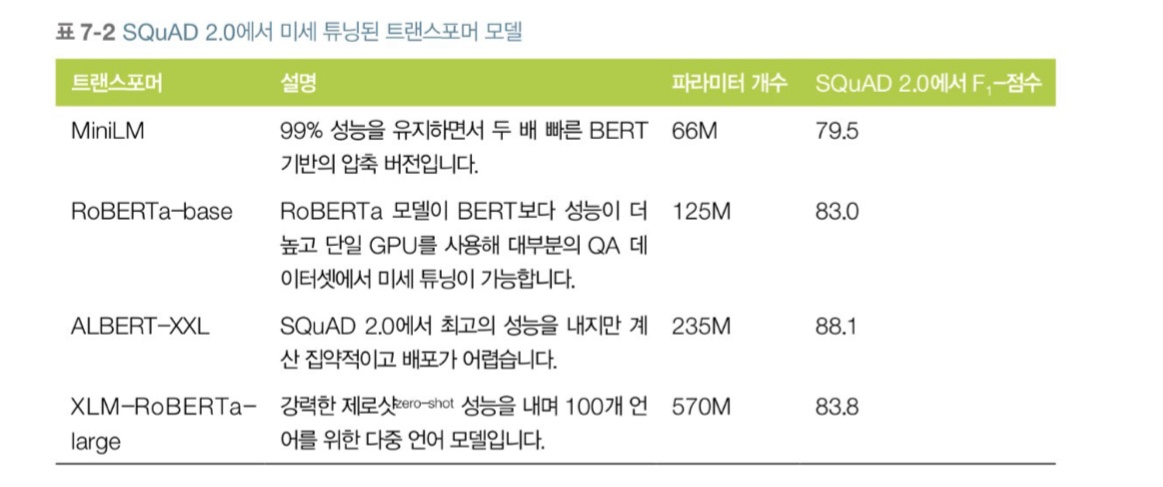

#### **QA를 위한 텍스트 토큰화**

텍스트를 인코딩할 토크나이저가 가장 먼저 필요

In [ ]:
#허깅페이스 허브에서 MiniLM 모델의 체크포인트를 로드하기

from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

모델을 작동해보기 위해 짧은 텍스트에서 답을 추출하기
- 추출적 QA에서는 입력을 (질문, 문맥) 쌍으로 제공하므로 두 값을 모두 토크나이저에 전달

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

결과로 파이토치 Tensor 객체가 반환되므로, 이를 사용해 모델의 정방향 패스를 실행해야한다
- input_ids
- attention_mask
- token_type_ids: 입력에서 어떤 부분이 질문과 문맥에 해당하는지 나타낸다 (0:질문 토큰 / 1:문맥 토큰)

In [ ]:
# 토큰화된 입력을 표로 확인하기
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


QA 샘플마다 **[CLS] 질문 토큰 [SEP] 문맥 토큰 [SEP]** 포맷으로 입력이 구성됨

첫 번째 [SEP] 토큰의 위치는 token_type_ids에 의해 결정됨

In [ ]:
#토크나이저가 QA작업에서 입력을 포맷팅하는 방법을 이해하기 위해 input_ids 텐서를 디코딩하기
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


QA헤드와 함께 모델 객체를 초기화하고, 입력을 정방향 패스에 통과시킨다



In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


QA헤드는 QuestionAnsweringModelOutput 객체를 출력함
- QA헤드는 인코더의 은닉 상태를 받아 시작과 종료 범위의 로짓을 계산하는 선형 층에 해당한다.
- QA 작업을 토큰 분류 형태로 다룬다는 의미
- 출력을 답의 범위로 변환하기 위해 먼저 시작과 종료 토큰의 로짓이 필요하다

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

로짓의 크기를 입력 ID와 비교

In [ ]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


두 로짓(시작, 종료)은 각 입력 토큰에 연관된다

큰 양수 로짓은 가능성이 높은 시작과 종료 토큰 후보에 해당
- 로짓이 가장 높은 시작 토큰 -> 1, 6000
- 로짓이 가장 높은 종료 토큰 -> minute, hours

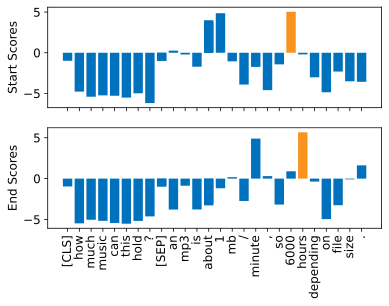

In [ ]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

최종 답을 얻기 위해 시작 토큰과 종료 토큰의 로짓에 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱


In [ ]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]

#결과를 디코딩해서 텍스트로 출력해 보기
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


🤗 트랜스포머는 이런 모든 전처리 단계와 후처리 단계가 전용 파이프라인에 안에 있다

토크나이저와 미세튜닝된 모델을 전달해 파이프라인을 초기화
- 답변 외에도 (로짓에 소프트맥스 함수를 적용해) 모델이 추정한 확률을 score 필드로 제공한다
- 한 문맥에서 여러 답을 비교할 때 편리하다
- topk 매개변수를 사용하면 모델이 여러 개의 답을 예측함
- answers.answer_start가 비어있는 SubjQA 샘플처럼 답변이 불가능한 질문도 있다
  - 이 경우, [CLS] 토큰에 높은 시작 점수와 종료 점수를 할당하고 파이프라인은 이 출력을 빈 문자열로 매핑한다

In [ ]:
from transformers import pipeline

#QA
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651619017124176, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082971036434174,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253506153821945,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [ ]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기

독해 모델의 결점: 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이를 초과한다

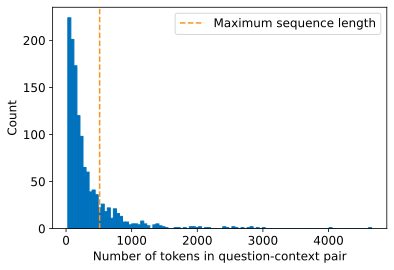

In [ ]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

#dfs -> dataframe
dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

#Figure는 그림이 보여지는 창 window을 의미하고 Axes은 그 창 안에 보여지는 그림
fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")

#세로 선 그리기
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

텍스트 분류 같은 그 외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분한 정보다 담겼다고 가정하고 그냥 긴 텍스트를 자름
- 하지만 QA작업에서는 이렇게 하면 문제가 생김
  - 질문의 답이 문맥의 끝에 있으면 텍스트를 잘랐을 때 답이 삭제될 수 있음

**슬라이딩 윈도**
각 윈도우는 모델의 문맥 크기에 맞는 토큰 리스트

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

🤗 트랜스포머스는 토크나이저에 return_overflowing_tokens=True 를 통해 슬라이딩 윈도우 생성
- 슬라이딩 윈도우의 크기는 max_seq_length 매개변수로
- 스트라이드의 크기는 doc_stride로 조절 (스트라이드 = 필터의 이동 횟수)


In [ ]:
#훈련 세트에 첫 번째 샘플 사용하여 슬라이딩 윈도우의 작동 방식 확인 -> 윈도마다 input_ids의 리스트를 하나씩 얻음

example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

In [ ]:
#각 윈도의 토큰 개수 확인
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


input_ids 디코딩으로 두 윈도가 어디서 겹치는 지 확인

In [ ]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### 헤이스택을 사용해 QA 파이프라인 구축하기

엔드-투-엔드 QA 파이프라인을 만드는 데 필요한 다른 구성 요소 알아보기

답변 추출 예제에서는 질문과 문맥을 모두 모델에 제공 -> 하지만 실제 사용자는 제품에 대한 질문만 제공함
- 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요함
  - 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입하는 방법
  - 하지만 사용자 쿼리에 대한 레이턴시를 수용하지 못함

결론: **리트리버-리더 구조**를 기반으로 문제를 처리한다
- 리트리버: 쿼리에서 관련된 **문서를 추출**
  - 희소 리트리버: 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현, 벡터의 내적을 계산해 쿼리와 문서의 관련성을 결정한다
  - 밀집 리트리버: 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩 (밀집 벡터)로 표현, 임베딩이 의미를 인코딩하므로 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상시킨다


- 리더: 리트리버가 제공한 문서에서 **답을 추출**


<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

Haystack 라이브러리: NLP 전문 독일 기업 딥셋이 개발
- 리트리버-리더 아키텍처를 기반
- 시스템 구축과 관련된 많은 복잡도를 추상화하며 🤗트랜스포머스와 긴밀하게 통합됨

Haystack으로 QA파이프라인을 만들 때 리트리버, 리더 외의 필요한 구성 요소
- 문서 저장소: 쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터베이스
- 파이프라인: 사용자 쿼리가 잘 흘러가도록 QA 시스템의 모든 구성요소를 결합하고 여러 리트리버에서 추출한 문서를 합치는 등의 기능

#### 문서 저장소 초기화하기

Haystack에서 사용 가능한 문서 저장소는 다양하고, 각 저장소마다 조합할 수 있는 전용 리트리버가 있음
* 이 장에서는 양쪽 리트리버에 모두 호환되는 ElasticsearchDocumentStore를 사용

ElasticSearch
- 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진
- 대용량 데이터를 저장하고 전체 텍스트 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 적절함
- 인프라 분석을 위한 업계 표준

In [ ]:
#일래스틱서치 다운로드 및 설치

url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스로 일래스틱서치를 실행합니다
# chown 셸 명령어 -> 서브프로세스를 백그라운드에서 실행
# Popen()함수를 사용하여 새로운 프로세스 시작
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

In [ ]:
# 또는 도커가 설치되어 있다면
from haystack.utils import launch_es

launch_es()

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "2dc915addfb7",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "YMMG5FOOQ2qmCuNqw10VXw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


문서 저장소 객체를 초기화

In [ ]:
# document_store --> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

ElasticsearchDocumentStore는 일래스틱서치에 두 개의 인덱스를 만든다
- document: 문서를 저장
- label: 답의 범위를 저장

Haystack 문서 저장소는 text와 meta 키를 가진 딕셔너리의 리스트를 기대한다
- meta에 있는 필드를 사용해 검색 과정에서 필터를 적용한다

제품과 질문 ID로 필터링할 수 있도록 SubjQA의 item_id와 id열, 그리고 해당되는 분할 이름 포함
각 DataFrame에 있는 샘플을 순회하면서 write_documents() 메서드로 인덱스를 추가한다

In [ ]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")

print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


- 모든 리뷰를 인덱스에 저장하기 작업 완료

#### 리트리버 초기화하기

인덱스를 검색하려면 리트리버가 필요하다 -> 일래스틱서치를 위한 리트리버를 만드는 법 타파하자!!!

헤이스택에서 일래스틱서치리트리버의 기본 리트리버는 BM25이다.

[일래스틱서치 문서 저장소는 모든 헤이스택 리트리버와 조합이 가능하다]
BM25 기반의 희소 리트리버
- 고전적인 TF-IDF 알고리즘을 개선한 버전
- 일래스틱 서치에서 효율적으로 검색할 수 있는 희소 벡터로 질문과 문맥을 표현
- BM25 점수: 검색 쿼리에서 얼마나 많은 텍스트가 일치하는지 측정
- TF값을 빠르게 포화시키고 짧은 문서가 긴 문서보다 선호되도록 문서 길이로 정규화해 TF-IDF를 개선

헤이스택에서 일래스틱서치리트리버의 기본 리트리버는 BM25이다.

헤이스택 1.4에서 `ElasticsearchRetriever`가 `BM25Retriever`로 바뀌었습니다. 여전히 버전 1.5에서 `ElasticsearchRetriever`를 사용할 수 있지만 향후 버전에서 삭제될 수 있습니다.

In [ ]:
from haystack.nodes.retriever import BM25Retriever

#검색하려는 저장소를 지정해 클래스의 객체 만들기
bm25_retriever = BM25Retriever(document_store=document_store)

[훈련 세트 중 한 전자 제품에 대한 간단한 쿼리 살펴보기]
- 리뷰 기반 QA시스템에서는 단일 아이템으로 쿼리를 제한하는 것이 중요!
  - 리트리버가 사용자 쿼리와 무관한 제품의 리뷰도 검색해버리기 때문
  - 예시: 카메라 성능에 대한 쿼리에 핸드폰인지 노트북인지???

[아마존의 파이어 태블릿 ID]
- 리트리버의 retrieve() 메서드를 사용해 이 제품이 독서에 유용한지 물어보기
- top_k: 얼마나 많은 문서를 반환할지
- meta 필드에 포함된 item_id, split 키에 모두 필터를 적용
- retrieved_docs의 각 원소: 문서를 나타내는데 사용하는 헤이스택의 document 객체
  (리트리버 쿼리 점수와 그 외 메타데이터를 포함하고 있음)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never  ...'>


결과로 문서 텍스트외에, score 필드도 확인 가능 -> 점수가 높을 수록 매칭이 잘 되었음을 의미

내부적으로 일래스틱서치는 인덱싱과 검색을 위해 루씬에 의존
- 따라서 기본적으로 루씬의 실용적인 스코어링 함수를 사용

스코어링 함수
- 불리언 텍스트를 사용해 후보문서를 필터링한 다음, 다음 문서와 쿼리의 벡터 표현을 기반으로 유사도를 측정함


#### 리더 초기화하기

문서에서 답을 추출할 방법이 필요함 -> 이 과정에 리더를 사용
- 헤이스택에 MiniLM을 로드하는 방법을 알아보자

헤이스택의 주어진 문맥에서 답을 추출하는 두 종류의 리더
1. FARMReader
  - 트랜스포머를 미세 튜닝하고 배포하는 딥셋의 FARM 프레임워크를 기반
  - 🤗 트랜스포머스를 사용해 훈련된 모델과 호환되며 허브에서 바로 모델을 로드 가능
2. TransformerReader
  - 🤗 트랜스포머스의 QA파이프라인을 기반으로 한다.
  - 추론만 실행하는 데 적합하다

두 리더가 모델의 가중치는 같은 방식으로 처리하지만, 예측을 반환해 답을 만드는 방식은 조금 다름
- 🤗 트랜스포머스에서 QA파이프라인은 각 구절의 시작 로짓과 종료 로짓을 소프트맥스로 정규화함. 따라서 확률의 합이 1이 되는 구절에서 추출한 답의 점수를 비교할 때만 의미있다.
- FARMReader에서는 로짓을 정규화하지 않아 구절 간의 답변이 더 쉽게 비교된다
- 트랜스포머스리더는 종종 같은 답을 다른 점수로 두 번 예측하는 경우가 있음. (가령 문맥이 길고 답이 충접된 윈도우에 놓인 경우). FARM에서는 이런 중복을 제거함.


리더를 미세튜닝하기 위해 FARMReader를 사용할 것이다

모델을 로드하려면 QA특화된 매개변수와 함께 허깅페이스 허브에 있는 MiniLM 체크포인트를 지정하면 된다.

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

FARMReader에서 슬라이딩 윈도의 동작 -> max_seq_length와 doc_stride 매개변수로 제어


In [ ]:
#리더 동작 결과 확인하기
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648089170455933,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293056815862656, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id':
'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


#### 모두 합치기
이제 헤이스택 파이프라인 중 하나를 활용해 구성 요소를 죄다 연결시키면 됨

헤이스택은 사례에 따라 쉽게 커스터마이징 가능한 그래프로 구성하는 Pipeline 추상화를 제공한다
- 🤗트랜스포머스에 있는 파이프라인과 비슷하지만 QA시스템에 특화된 사전정의된 파이프라인도 있다
- 매개변수로 하나의 리트리버-리더 쌍을 받는 ExtractiveQAPipeline을 사용할 예정 (답 추출에 초점)

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

각 파이프라인은 run() 메서드를 가지고 있고, 쿼리가 어떻게 실행해야하는지 지정한다
- query, top_k_retriever: 추출할 문서 개수
- top_k_reader: 문서에서 추출할 답 개수를 전달
- filters: 아이템 ID에 대한 필터 지정

In [ ]:
n_answers = 3
preds = pipe.run(query=query,
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx].answer}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx].context}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 3:
해당 리뷰 텍스트: ...None...





아마존 제품 리뷰를 위한 엔드-투-엔드 QA시스템 완성
- 하지만 성능을 더 높이자^^
  - 리트리버와 리더의 성능을 정량화할 지표가 필요

## QA 파이프라인 개선하기

- 최근 QA 연구들은 독해 모델을 개선하는 데 집중한다
- 하지만 리트리버가 전체 시스템 성능의 상한선을 설정하므로 리트리버의 성능이 중요함

### 리트리버 평가하기

리트리버를 평가해 희소와 밀집 표현의 성능을 비교할 수 있는 일반적인 지표
- 재현율: 추출된 관련 문서의 비율을 측정
  - "관련" : 단순히 답이 텍스트 안에 있는지 없는지를 의미
  - 일련의 질문이 주어질 때, 리트리버가 반환한 최상위 k개 문서에 답이 등장한 횟수를 카운트

헤이스텍에서 리트리버를 평가하는 두 가지 방법
1. 리트리버가 제공하는 eval() 메서드 사용
2. EvalDocuments 클래스와 리트리버를 결합하는 사용자 정의 파이프라인을 만든다

In [ ]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [ ]:
"""
[실습 버전1에는 있고 2에는 없는 코드]

from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever",
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
                      inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)
"""

'\nfrom haystack.pipeline import Pipeline\nfrom haystack.eval import EvalDocuments\n\nclass EvalRetrieverPipeline:\n    def __init__(self, retriever):\n        self.retriever = retriever\n        self.eval_retriever = EvalDocuments()\n        pipe = Pipeline()\n        pipe.add_node(component=self.retriever, name="ESRetriever",\n                      inputs=["Query"])\n        pipe.add_node(component=self.eval_retriever, name="EvalRetriever",\n                      inputs=["ESRetriever"])\n        self.pipeline = pipe\n\n\npipe = EvalRetrieverPipeline(es_retriever)\n'

쿼리와 이에 해당하는 답을 전달하는 과정
- 문서 저장소에 있는 전용 label 인덱스에 답을 추가 (헤이스택은 표준 방식으로 답 범위와 메타 데이터를 나타내는 Label 객체를 제공함)
- label 인덱스를 채우기 위해 먼저 테스트 세트에 있는 질문을 순회하면서 답과 추가적인 메타 데이터를 추출하여 Label 객체의 리스트 만들기

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가합니다
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

레이블 중 하나를 추출해보면, 질문 답변 쌍과 쿼리마다 문서 저장소를 필터링할 수 있는 고유한 질문 ID가 담긴 origin필드가 있음을 확인가능

+) 제품으로 레이블을 필터링하기 위해 meta 필드에 제품 ID가 추가되어있음

In [ ]:
print(labels[0])

<Label: {'id': '0f7769f7-be36-4798-a992-e325360c705a', 'query': 'What is the
tonal balance of these headphones?', 'document': {'content': "I have been a
headphone fanatic for thirty years and have owned and used a variety of
headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.
The Sony MDRV6 excells as the best value of any headphone that I've ever owned.
They are especially good at producing natural-sounding deep bass, and the
overall octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the velour pads from BeyerDynamic.  The pads tha

- 준비된 레이블들을 일랙스틱서치의 label 인덱스에 저장한다

In [ ]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

455개의 질문 답변 쌍을 로드했습니다.


파이프라인에 전달하기 위해 질문 ID와 이에 상응하는 답변을 매핑
- get_all_labels_aggregated() : 고유 ID를 가진 모든 질문-답변 쌍을 가져오기
  - 반환 값: MultiLabel 객체의 리스트
  - 질문ID로 필터링하게 되면 하나의 원소만 반환되지만, 아래 코드처럼 작성하면 레이블의 리스트를 만들 수 있음

In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


- 레이블 하나를 프린트해보면 질문 하나에 연관된 모든 답들이 multiple_answers 필드에 있음을 확인 가능하다

In [ ]:
print(labels_agg[100])

파이프라인에 레이블을 넣고 pipe 객체에서 추출이 올바르게 되는지 평가

In [ ]:
# 다음처럼 원하는 top_k 값으로 파이프라인을 실행할 수 있습니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.96


In [ ]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


어떤 k값을 선택할지 결정할 때 도움이 되도록 몇 개의 k값을 반복하고 각 k에서 전체 테스트 세트의 재현율을 계산하는 함수를 만든다

In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k를 계산합니다
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k로 추론을 실행합니다
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

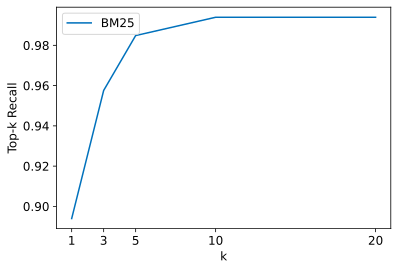

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

#### DPR

희소 리트리버는 k=10개에서 거의 완벽한 재현율을 달성한다 -> k가 그보다 작을 때도 성능을 높일 방법이 있을 것인가

희소리트리버의 단점
- 사용자 쿼리의 단어가 리뷰에 없으면 연관된 문서를 검색하지 못할 수 있다

단점에 대한 대안
- 밀집 임베딩을 사용해 질문과 문서를 표현하기 -> DPR이라는 구조가 현재 최고의 성능을 가지고 있음

DPR
- 두 개의 BERT 모델을 사용하여 질문과 구절을 인코딩한다는 개념에 기반
- 인코더는 입력 텍스트를 [CLS]토큰의 d차원 벡터 표현으로 매핑한다

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

헤이스택에서 DPR을 위한 리트리버를 만드는 방식은 BM25와 유사하다
1. 문서 저장소를 지정하고 질문과 구절을 위한 BERT 인코더를 선택
2. 선택한 인코더에 관련된 구절(양성)과 무관한 구절(음성)을 질문과 함께 주입하여 훈련한다

목표: 연관된 질문-구절 쌍이 높은 유사도를 가지도록 학습하기

예제
- NQ 말뭉치에서 미세 튜닝한 인코더를 사용
- 제품으로 필터링하여 문서제목 (item_id)을 연결해 추가 정보를 얻지 못하기 때문에 embed_title=False로 지정

In [ ]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

밀집 리트리버를 초기화한 후, 일래스틱서치에 인덱스된 문서를 모두 순회하면서 인코더를 적용해 임베딩 표현 업데이트

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

BM25와 같은 방식으로 밀집 리트리버 평가 & top_k 재현율 비교

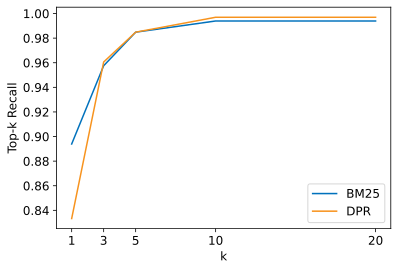

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

###어라랏

결과를 보니, DPR은 BM25보다 재현율이 높지 않으며, k=3에서 비슷하다

(BM25의 단점을 보완했다며..? DPR이 최고의 성능을 가지고 있다며..? 사기당했나)

### 리더 평가하기

추출적 QA에서 리더를 평가하는 주요 지표
1. EM (Exact Match)
- EM=1 (예측과 정답에 있는 문자가 정확히 일치)인 경우와 EM=0 (일치하지 않음)인 경우로 나뉘는 이진 지표

2. F1-점수
- 정밀도와 재현율의 조화 평균을 측정한다

FARM에서 헬퍼 함수를 임포트하고 간단한 샘플에 적용해 지표의 작동 방식을 파악해보자

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact
#from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


함수 작동 방식
1. 구두점 삭제, 공백 수정, 소문자 변환을 적용해 예측과 레이블을 정규화
2. 정규화된 문자열을 BoW로 토큰화
3. 토큰 수준에서 측정 지표를 계산한다

* EM은 F1점수보다 더 엄격한 지표이다.
  - 예측에 토큰이 하나라도 더 추가되면 EM=0이 되지만, F1-점수는 잘못된 답을 잡아내지 못하는 경우도 있다

In [ ]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


F1-점수에만 의존하면 결과가 왜곡될 가능성이 존재
- 두 지표를 모두 참고해 그 사이에 균형을 잡는 것이 좋은 전략

보통 질문에는 유효한 답이 여러 개 존재
1. 평가 세트에 있는 각각의 질문-답 쌍에 대해 지표를 계산하고 가능한 답 중 가장 좋은 점수 선택
2. 각각의 질문-답 쌍의 개별 점수를 평균해 모델의 전체적인 EM과 F1-점수를 구한다

**리더를 평가하기 위한 파이프라인 만들기**
- 노드가 두 개: 리더 노드 & 리더를 평가할 노드
  - EvalAnswers 클래스 사용: 리더의 예측을 받아 EM과 F1-점수를 계산
  - SQuAD 평가와 비교하기 위해 EvalAnswers에 저장된 top_1_em과 top_1_f1점수로 쿼리마다 최상의 답을 선택

In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

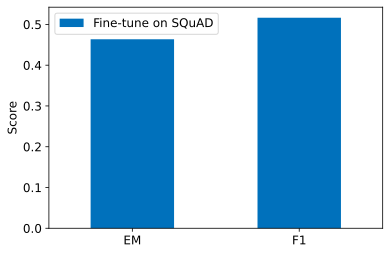

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

MiniLM이 SQuAD 2.0 (EM 76.1, F1-점수 79.5)보다 SubjQA에서 모델의 성능이 크게 떨어지는 것 같다.
- 성능 저하의 이유
  - 리뷰가 자유로운 형식으로 쓰였기 때문
  - 위키피디아에 있는 사실 정보와 달리, 데이터셋의 질문과 답엔 주관성이 내재되어있다.

### 도메인 적응
모델을 SubjQA에서 미세 튜닝하면 더 나은 결과가 나올까?

SQuAD에서 미세 튜닝한 모델을 대개 다른 도메인에 잘 일반화되지만, SubjQA에서의 평가는 SQuAD보다 훨씬 나쁘다.
- 일반화 실패의 이유: 트랜스포머 모델이 SQuAD 데이터셋에 과대적합된 증거가 아닐까

리더의 성능을 가장 쉽게 향상시키는 방법: MiniLM 모델을 SubjQA 훈련 세트에 미세튜닝시킨다.
- FARMReader에는 train() 메서드가 있음 -> SQuAD JSON 포맷으로 데이터를 입력받는다 -> 이 포맷은 아이템마다 질문-답 쌍을 모두 합친 것

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

복잡한 데이터 포맷을 판다스를 사용해 변환하기
1. 각 제품 ID에 연관된 paragraphs 배열을 만드는 함수 구현
  - 배열의 원소는 하나의 문맥과 질문-답 쌍의 배열인 qas를 담고 있다

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링합니다
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열을 만듭니다
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링합니다
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문을 추가합니다
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가합니다
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가합니다
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

2. 하나의 제품 ID에 연관된 DataFrame의 열을 전달해 SQuAD 포맷을 만든다

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

3. 이 함수를 각 분할의 DataFrame에 있는 모든 제품 ID에 적용한다.
- convert_to_squad는 이 과정을 수행하고 그 결과를 electronics-{split}.json 파일에 저장한다

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs`를 만듭니다
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장합니다
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

리더를 미세튜닝하기
- 훈련 분할과 개발 분할의 위치와 미세 튜닝한 모델을 저장할 위치 지정

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12426.51 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing lo

미세 튜닝된 리더의 테스트 세트 성능을 기준 모델과 비교

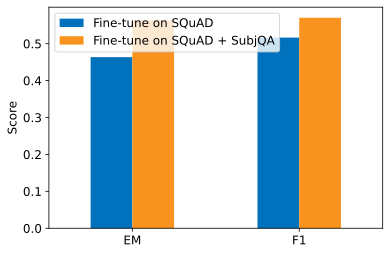

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

-> 점수가 매우 향상 되었음을 확인할 수 있음

사전 훈련된 모델을 바로 SubjQA 훈련 세트에 미세 튜닝하지 않는 이유
- SQuAD의 샘플이 SubjQA의 훈련 샘플보다 월등히 많아 과대 적합이 발생할 수 있다

과적합때문에 성능이 떨어질 걸 알지만 한 번 해보자
- SQuAD에서 기준 모델을 미세 튜닝할때 사용한 언어 모델을 그대로 사용
- 이전처럼 FARMReader로 모델을 로드


In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12584.54 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing lo

테스트 성능 비교 결과


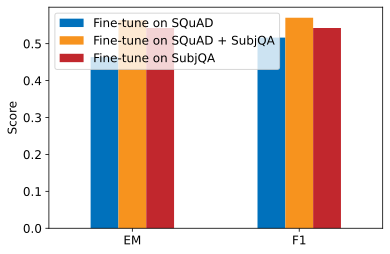

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### 전체 QA 파이프라인 평가하기
리더와 리트리버를 개별적으로 평가하는 방법을 연결해 전체 파이프라인 평가를 해보자
- 리트리버 파이프라인에 리더와 리더의 평가노드 추가

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

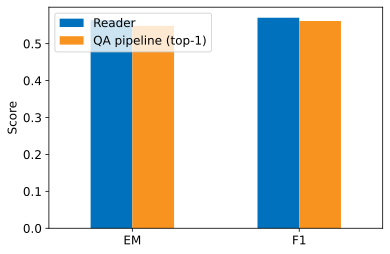

In [ ]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

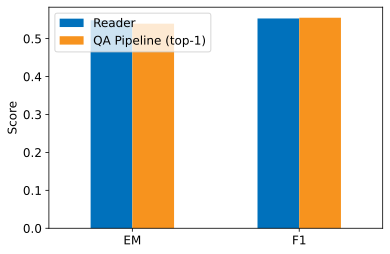

In [ ]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻습니다
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됩니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출합니다
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## 추출적 QA를 넘어서

지금까지 문맥에서만 답 범위를 추출했지만 보통 답은 문서 전체에 흩어져 있다.

-> 모델이 조각을 모아 일관된 하나의 답으로 합성해야 한다.

-> 생성적 QA를 사용하는 방법을 알아보자

**추상적 QA 또는 생성적 QA**
- 사전 훈련된 언어 모델로 답을 생성하는 것
- 여러 구절에 흩어진 증거를 합성해 더 나은 문장으로 답을 구성한다

**RAG**
- 고전적인 리트리버-리더 구조를 확장
- 리더 -> 제너레이터, 리트리버로 DPR 사용
  - 제너레이터란 T5나 BART 같은 사전 훈련된 시퀀스-투-시퀀스 트랜스포머이다
  - DPR로부터 문서의 잠재 벡터를 받고 쿼리와 문서를 기반으로 답변을 반복적으로 생성한다.
  - DPR과 제너레이터가 미분 가능하기 때문에 전체 과정을 엔드-투-엔드로 미세 튜닝할 수 있다

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>

앞서서 만든 dpr_retriever를 사용할 예정이므로, 제너레이터만 만들만 된다.
두가지 모델 중 선택가능

**RAG-시퀀스**
- 하나의 추출 문서를 사용해 완전한 답을 생성한다.
- 리트리버가 반환한 top-k개 문서를 제너레이터에 주입해 각 문서에서 출력 시퀀스를 만들고 이 결과를 합쳐 최선의 답을 얻음

**RAG-토큰**
- 여러 문서를 사용해 답에 있는 토큰을 생성
- 제너레이터가 여러 문서에서 단서를 찾아 합성

토큰 모델이 시퀀스 모델보다 성능이 좋으니 NQ에서 미세 튜닝한 토큰 모델을 제너레이터로 사용.

헤이스택에서 제너레이터를 초기화하는 것은 리더를 초기화하는 것과 비슷하다.
- 하지만 문맥 위를 슬라이딩하는 위도를 위해 max_seq_length와 doc_stride 매개변수를 지정하는 대신
- 텍스트 생성을 제어하는 하이퍼파라미터를 지정할 것임

- num_beams: 빔 서치에 사용할 빔 크기 지정
- 말뭉치를 항상 제품 ID로 필터링하기 때문에 DPR 리트리버에서 했던 것처럼 문서 제목을 임베딩하지 않음


In [ ]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

헤이스택의 GenerativeQAPipeline을 사용하여 리트리버와 제너레이터를 연결

In [ ]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

아마존 파이어 태블릿에 대한 쿼리를 주입해 RAG 실행
- 쿼리를 받고 최상의 답을 출력하는 간단한 함수 작성

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"질문: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:2141: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


질문: Is it good for reading?

답변 1:  the screen is absolutely beautiful
답변 2:  the Screen is absolutely beautiful
답변 3:  Kindle fire


- 위 질문의 주관적인 점이 제너레이터를 혼동시킨다 -> 조금 더 사실적인 질문을 던져보자

In [ ]:
generate_answers("What is the main drawback?")

질문: What is the main drawback?

답변 1:  the price
답변 2:  no flash support
답변 3:  the cost


- 더 나은 결과를 얻게 되었다
- SubjQA에서 엔드-투-엔드로 RAG를 미세 튜닝한다면 더 좋은 결과를 얻을 것이다

## 결론

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/>

<QA 요구 계층>

**흥미로운 분야들**
1. 멀티모달 QA
2. 지식 그래프에 대한 QA
3. 자동 질문 생성